In [2]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import stats
plt.rc('text', usetex=True)
plt.rc('font',size=14)

In [3]:
k_B_T = 0.5
f = h5py.File(dir_path+'DoubleWell/simulations/simulation_k_B_T_{}.h5'.format(k_B_T),'r')
sim = np.array(f['simulation'])
T = np.array(f['MetaData/T'])[0]
discard_t = np.array(f['MetaData/discarded_t'])[0]
dt = np.array(f['MetaData/integration_step'])[0]
print(sim.shape)
f.close()
print(dt,discard_t)
f = h5py.File(dir_path+'DoubleWell/embedding/phspace_k_B_T_{}.h5'.format(k_B_T),'r')
# print(list(f.keys()))
traj_matrix = np.array(f['traj_matrix'])
K_star = np.array(f['K_star'],dtype=int)[0]
m_star = np.array(f['m_star'],dtype=int)[0]
phspace = np.array(f['phspace'])
print(traj_matrix.shape)
f.close()


f = h5py.File(dir_path+'DoubleWell/tscales_compute_1000_clusters.h5','r')
print(list(f.keys()))
T_range = np.array(list(f.keys()),dtype='float')
ts_traj_T = []
for T in T_range:
    ts_traj_delay = np.array(f[str(T)]['ts_traj_delay'])
    delay_range = np.array(f[str(T)]['delay_range'])
    length = int(np.array(f[str(T)]['seq_length'])[0])
    ts_traj_T.append(ts_traj_delay)
f.close()

print(length*dt)

ts_traj_delay = ts_traj_T[0]

(20000000, 2)
0.05 1000.0
(19999993, 7)
['0.5', '0.75', '1.0', '1.25', '1.5', '1.75', '2.0', '2.25', '2.5']
50000.00074505806


In [5]:
n_clusters=1000
f = h5py.File(dir_path+'DoubleWell/symbol_sequences/labels_phspace_k_B_T_{}_nseeds_{}.h5'.format(k_B_T,n_clusters),'r')
labels_traj = np.array(f['labels_traj'],dtype=int)
centers_traj = np.array(f['centers_traj'])
labels_phspace = np.array(f['labels_phspace'],dtype=int)
centers_phspace = np.array(f['centers_phspace'])
f.close()

# Projected Boltzmann distribution

In [4]:
def Boltzmann_dist(x,y,k_B_T,gamma=1):
    beta = 1/k_B_T
    return np.exp(-beta*((x**2-1)**2+gamma*y**2/2))

from sklearn.linear_model import LinearRegression

X = sim[int(K_star/2):-int(K_star/2)-1,:]
y = phspace[:,:2]
reg = LinearRegression().fit(X, y)

R2 = reg.score(X, y)

m = reg.coef_

b = reg.intercept_

centers_proj = centers_phspace.dot(np.linalg.pinv(m))

P_B_phspace = np.array([Boltzmann_dist(x_,y_,k_B_T) for x_,y_ in centers_proj])
P_B_phspace = P_B_phspace/P_B_phspace.sum()

# operator time scales 

In [5]:
mean = np.mean(ts_traj_delay[:,:,0],axis=0)
cil = np.percentile(ts_traj_delay[:,:,0],2.5,axis=0)
ciu = np.percentile(ts_traj_delay[:,:,0],97.5,axis=0)

mean_1 = np.mean(ts_traj_delay[:,:,1],axis=0)
cil_1 = np.percentile(ts_traj_delay[:,:,1],2.5,axis=0)
ciu_1 = np.percentile(ts_traj_delay[:,:,1],97.5,axis=0)

In [6]:
kd=199
delay = int(delay_range[kd])
print(delay*dt)
P = op_calc.transition_matrix(labels_phspace,delay)
prob = op_calc.stationary_distribution(P)
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10)

PF_eigvecs = op_calc.sorted_spectrum(R.T,k=10)[1]

10.000000149011612


In [7]:
sizes = np.array([np.var(phspace[labels_phspace==label,:2] - centers_phspace[label]) for label in np.unique(labels_phspace)])
p_phspace = prob/sizes
p_phspace = p_phspace/p_phspace.sum()

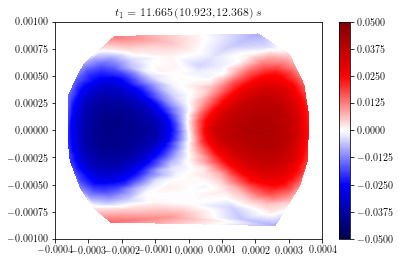

In [8]:
plt.figure()
plt.title('$t_1 = {:.3f}\,({:.3f},{:.3f}) \, s$'.format(mean[kd],cil[kd],ciu[kd]))
plt.tricontourf(centers_phspace[:,0],centers_phspace[:,1],eigvecs[:,1].real,cmap='seismic',levels=np.linspace(-.05,.05,1000))
plt.xlim(-0.0004,0.0004)
plt.ylim(-0.001,0.001)
plt.colorbar(ticks = np.linspace(-0.05,0.05,9))
# plt.savefig('Koopman_eigfun_DW_k_B_T_{}_delay_Fig.pdf'.format(k_B_T))
plt.show()

# Fig4B_simulation

In [9]:
idx = np.argmin(np.linalg.norm(centers_phspace-np.array([0.00025,0]),axis=1))
rho_0 = np.zeros(n_clusters)
rho_0[idx] = 1

n_iters= int(10000/delay)
new_rho = np.zeros((n_iters,n_clusters))
new_rho[0] = rho_0
for k in range(n_iters-1):
    new_rho[k+1,:] = (P.T).dot(new_rho[k])

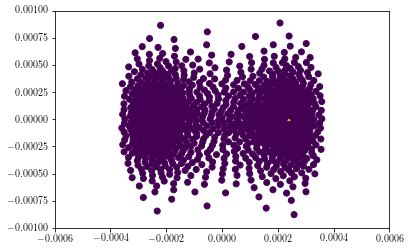

In [10]:
plt.scatter(centers_phspace[:,0],centers_phspace[:,1],c=new_rho[0]/sizes)
plt.xlim(-0.0006,0.0006)
plt.ylim(-0.001,0.001)
plt.show()

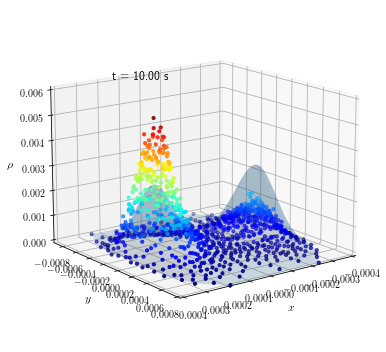

In [11]:
k=1
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d',)
ax.view_init(elev=15., azim=53)
p = new_rho[k,:]/sizes
p = p/p.sum()
# ax.plot_trisurf(centers[:,0],centers[:,1],p,alpha=.5,cmap='jet')
ax.scatter(centers_phspace[:,0],centers_phspace[:,1],p,cmap='jet',c=p,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
ax.plot_trisurf(centers_phspace[:,0],centers_phspace[:,1],P_B_phspace/P_B_phspace.sum(),alpha=.2)#,cmap='jet',c=prob,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
# plt.axis('off')
ax.zaxis.set_rotate_label(False) 
ax.set_xlabel(r'$x$',fontsize=12)
ax.set_ylabel(r'$y$',fontsize=12)
ax.set_zlabel(r'$\rho$',fontsize=12,rotation=0)
# ax.set_zlim(0,0.08)
ax.set_xlim(-4e-4,4e-4)
ax.set_ylim(-9e-4,8e-4)
ax.set_zlim(0,6e-3)
ax.text2D(-.05, .05,  "t = {:.02f} s".format(k*delay*dt), color='k',fontsize=12)
plt.tight_layout()
# plt.savefig('img_{:05d}_k_B_T_{}.pdf'.format(k,k_B_T))
plt.show()

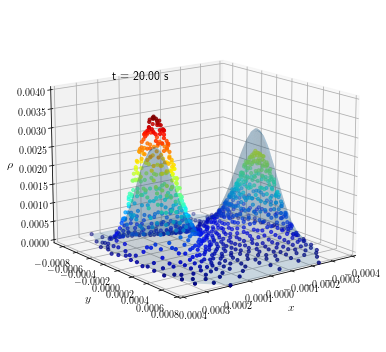

In [12]:
k=2
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d',)
ax.view_init(elev=15., azim=53)
p = new_rho[k,:]/sizes
p = p/p.sum()
ax.scatter(centers_phspace[:,0],centers_phspace[:,1],p,cmap='jet',c=p,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
ax.plot_trisurf(centers_phspace[:,0],centers_phspace[:,1],P_B_phspace/P_B_phspace.sum(),alpha=.2)#,cmap='jet',c=prob,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
ax.zaxis.set_rotate_label(False) 
ax.set_xlabel(r'$x$',fontsize=12)
ax.set_ylabel(r'$y$',fontsize=12)
ax.set_zlabel(r'$\rho$',fontsize=12,rotation=0)
ax.set_xlim(-4e-4,4e-4)
ax.set_ylim(-9e-4,8e-4)
ax.set_zlim(0,4e-3)

ax.text2D(-.05, .05,  "t = {:.02f} s".format(k*delay*dt), color='k',fontsize=12)
plt.tight_layout()
# plt.savefig('img_{:05d}_k_B_T_{}.pdf'.format(k,k_B_T))
plt.show()

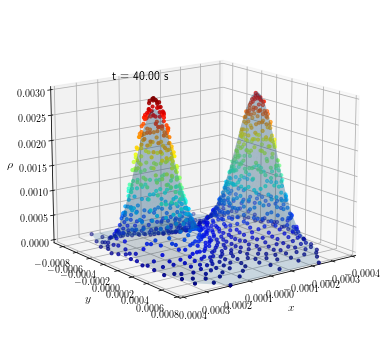

In [13]:
k=4
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d',)
ax.view_init(elev=15., azim=53)
p = new_rho[k,:]/sizes
p = p/p.sum()
ax.scatter(centers_phspace[:,0],centers_phspace[:,1],p,cmap='jet',c=p,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
ax.plot_trisurf(centers_phspace[:,0],centers_phspace[:,1],P_B_phspace/P_B_phspace.sum(),alpha=.2)#,cmap='jet',c=prob,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
ax.zaxis.set_rotate_label(False) 
ax.set_xlabel(r'$x$',fontsize=12)
ax.set_ylabel(r'$y$',fontsize=12)
ax.set_zlabel(r'$\rho$',fontsize=12,rotation=0)
ax.set_xlim(-4e-4,4e-4)
ax.set_ylim(-9e-4,8e-4)
ax.set_zlim(0,3e-3)

ax.text2D(-.05, .05,  "t = {:.02f} s".format(k*delay*dt), color='k',fontsize=12)
plt.tight_layout()
# plt.savefig('img_{:05d}_k_B_T_{}.pdf'.format(k,k_B_T))
plt.show()

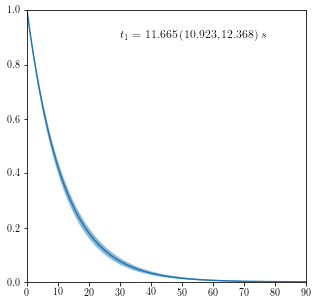

In [14]:
t_range = np.arange(0,200)
plt.figure(figsize=(5,5))
plt.plot(t_range,np.exp(-(1/mean[kd])*t_range))
plt.fill_between(t_range,np.exp(-(1/cil[kd])*t_range),np.exp(-(1/ciu[kd])*t_range),alpha=.5)

plt.xlim(0,90)
plt.ylim(0,1)
plt.text(30,0.9,'$t_1 = {:.3f}\,({:.3f},{:.3f}) \, s$'.format(mean[kd],cil[kd],ciu[kd]),fontsize=12)
# plt.savefig('eigfun_decay_k_B_T_{}.pdf'.format(k_B_T))
plt.show()

# Hopping rates

In [15]:
from sklearn.linear_model import LinearRegression

def decay_rate(lifetimes,xrange=[2,500],plot=False,min_counts=10):
    x,y = stats.cumulative_dist(lifetimes,xrange)
    y = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    counts = np.array([np.sum(x==x_unique) for x_unique in np.unique(x)])
    sel = counts>min_counts
    logy = np.log(y[sel])
    x = np.sort(np.unique(x))[sel].reshape(-1,1)
    w = counts[sel]
    y = y[sel]

    reg = LinearRegression().fit(x, logy)#,sample_weight=w)
    R2 = reg.score(x, logy)

    m = reg.coef_

    b = reg.intercept_
    
    if plot==True:
        plt.title('m = {:.2f}; R2 = {:.5f}'.format(-1/m[0],R2))
        plt.scatter(x,y)
        plt.plot(x,np.exp(m*x+b))
        plt.yscale('log')
        plt.show()
    return np.abs(m[0])

In [16]:
# participation ratio is probably not a good idea either!!!
    
delay_idx_T = np.zeros(len(T_range),dtype=int)
rate_mix_T = np.zeros((len(T_range),3))
delay_mix_T = np.zeros((len(T_range),3))
for kt,T in enumerate(T_range):
    ts_traj_delay = ts_traj_T[kt]
    mean = np.mean(1/ts_traj_delay[:,:,0],axis=0)
    cil = np.percentile(1/ts_traj_delay[:,:,0],0.5,axis=0)
    ciu = np.percentile(1/ts_traj_delay[:,:,0],99.5,axis=0)
    std = np.std(1/ts_traj_delay[:,:,0],axis=0)/2
    kd = np.argmax(mean)
    print(kd,delay_range[kd]*dt)
    rate_mix_T[kt,:] = np.array([mean[kd],cil[kd],ciu[kd]])
    delay_idx_T[kt] = delay_range[kd]
    mean = np.mean(ts_traj_delay[:,:,0],axis=0)
    cil = np.percentile(ts_traj_delay[:,:,0],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,0],97.5,axis=0)
    delay_mix_T[kt,:] = np.array([mean[kd],cil[kd],ciu[kd]])

345 17.300001
194 9.75
140 7.05
117 5.9
98 4.9500003
81 4.1
72 3.65
69 3.5
66 3.3500001


In [17]:
def obtain_tscales_T(kt,k_B_T,delay,length,plot=False):
    f = h5py.File(dir_path+'DoubleWell/symbol_sequences/labels_phspace_k_B_T_{}_nseeds_1000.h5'.format(k_B_T),'r')
    labels = ma.array(f['labels_traj'],dtype=int)
    centers = np.array(f['centers_traj'])
    f.close()
    
    f = h5py.File(dir_path+'DoubleWell/simulations/simulation_k_B_T_{}.h5'.format(k_B_T),'r')
    sim = np.array(f['simulation'])[int(K_star/2):-int(K_star/2)-1]
    f.close()   
    print(labels.shape,sim.shape)

    
    print(k_B_T,delay)
    lcs,P = op_calc.transition_matrix(labels,delay,return_connected=True)
    inv_measure = op_calc.stationary_distribution(P)
    final_labels = op_calc.get_connected_labels(labels,lcs)
    n_modes=2
    R = op_calc.get_reversible_transition_matrix(P)
    eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
    eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
    phi2 = eigfunctions[:,1]
        
    #label according to potential
    cluster_traj = ma.zeros(labels.shape,dtype=int)
    cluster_traj[sim[:,0]>0] = 1
    
    split_trajs = op_calc.get_split_trajs(cluster_traj,int(length))
    data_decay_rates = []
    data_decay_times = []
    for traj in split_trajs:
        data_lifetimes = stats.state_lifetime(ma.masked_invalid(traj),dt)
        data_decay_rate = decay_rate(np.hstack(data_lifetimes),xrange=[2,500],plot=plot,min_counts=1)
        data_decay_times.append(1/data_decay_rate)
        data_decay_rates.append(data_decay_rate)
    
    #save optimal partition results
    c_range,rho_sets,_,_ = op_calc.optimal_partition(phi2,inv_measure,R,return_rho=True)
        
    return c_range,rho_sets,data_decay_times,data_decay_rates

In [18]:
Tmin=0
scaled_T = (T_range - Tmin) / T_range.ptp()

colors_ = plt.cm.Reds(scaled_T)

In [19]:
nseqs = len(op_calc.get_split_trajs(labels_phspace,length))

tscales_T = np.zeros((len(T_range),nseqs))
decay_rates_T = np.zeros((len(T_range),nseqs))
plt.figure(figsize=(5,5))
crange_T = []
rho_sets_T = []
for kt,k_B_T in enumerate(T_range):
    delay=delay_idx_T[kt]
    print(delay*dt)
    c_range,rho_sets,data_tscales,data_decay_rates = obtain_tscales_T(kt,k_B_T,delay,length)
    tscales_T[kt] = np.array(data_tscales)
    decay_rates_T[kt] = np.array(data_decay_rates)
    crange_T.append(c_range)
    rho_sets_T.append(rho_sets)
    print(np.mean(data_tscales),np.mean(data_decay_rates))

17.30000025779009
(19999993,) (19999993, 2)
0.5 346
20.640159714107313 0.04850871321959366
9.750000145286322
(19999993,) (19999993, 2)
0.75 195
9.990568738862944 0.10015647340013334
7.050000105053186
(19999993,) (19999993, 2)
1.0 141
6.767527985088549 0.1478371865212783
5.900000087916851
(19999993,) (19999993, 2)
1.25 118
5.178023352298604 0.1932523201541761
4.950000073760748
(19999993,) (19999993, 2)
1.5 99
4.290176141388663 0.23316663243607866
4.100000061094761
(19999993,) (19999993, 2)
1.75 82
3.6794026908917563 0.2719586022391492
3.6500000543892384
(19999993,) (19999993, 2)
2.0 73
3.305478430430269 0.3026260458379643
3.500000052154064
(19999993,) (19999993, 2)
2.25 70
3.0017142898757188 0.333267812770734
3.35000004991889
(19999993,) (19999993, 2)
2.5 67
2.765419769928233 0.36169491588261643


<Figure size 360x360 with 0 Axes>

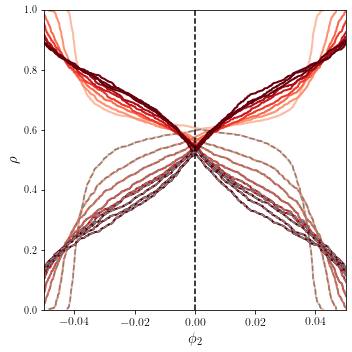

In [20]:
plt.figure(figsize=(5,5))
for kt,k_B_T in enumerate(T_range):
    c_range = crange_T[kt]
    rho_sets = rho_sets_T[kt]
    plt.plot(c_range,rho_sets[:,0],lw=2,c=colors_[kt])
    plt.plot(c_range,rho_sets[:,1],lw=2,c=colors_[kt])
    rho_c = np.min(rho_sets,axis=1)
    plt.plot(c_range,rho_c,c='gray',ls='--')
plt.ylim(0,1)
plt.xlim(-0.05,0.05)
plt.axvline(0,ls='--',c='k')
plt.xlabel(r'$\phi_2$',fontsize=15)
plt.ylabel(r'$\rho$',fontsize=15)
plt.xticks(fontsize=12)
plt.tight_layout()
# plt.savefig('coherence_DW.pdf')
# plt.xlim(-0.04,0.04)
plt.show()

In [21]:
decay_rates_T_ci = np.vstack([np.mean(decay_rates_T,axis=1),np.percentile(decay_rates_T,2.5,axis=1),np.percentile(decay_rates_T,97.5,axis=1)]).T
tscales_T_ci = np.vstack([np.mean(tscales_T,axis=1),np.percentile(tscales_T,2.5,axis=1),np.percentile(tscales_T,97.5,axis=1)]).T

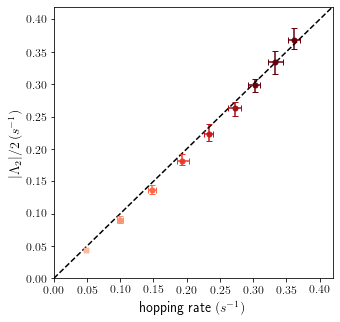

In [22]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(0,.51,.02),np.arange(0,.51,.02),ls='--',c='k')

for kt in np.arange(len(T_range)):
    cil_PF = rate_mix_T[kt,0]-rate_mix_T[kt,1]
    ciu_PF = rate_mix_T[kt,2]-rate_mix_T[kt,0]
    cil_data = decay_rates_T_ci[kt,0]-decay_rates_T_ci[kt,1]
    ciu_data = decay_rates_T_ci[kt,2]-decay_rates_T_ci[kt,0]
    plt.errorbar(decay_rates_T_ci[kt,0],.5*rate_mix_T[kt,0],
                 yerr = [[.5*cil_PF],[.5*ciu_PF]],xerr = [[cil_data],[ciu_data]], c=colors_[kt],capsize=3,fmt='o',ms=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('hopping rate $(s^{-1})$ ',fontsize=14)
plt.ylabel('$|\Lambda_2|/2\, (s^{-1})$ ',fontsize=14)
plt.xlim(0,0.42)
plt.ylim(0,0.42)

# plt.savefig('hopping_rate_diagonal_idx_{}.pdf'.format(idx))
plt.show()

In [23]:
half_tscales_T_ci = np.vstack([np.mean(tscales_T*.5,axis=1),np.percentile(tscales_T*.5,2.5,axis=1),np.percentile(tscales_T*.5,97.5,axis=1)]).T

In [24]:
y_operator = []
y_data = []
for kt in range(len(T_range)):
    ts_traj_delay = ts_traj_T[kt] #operator
    mean = np.mean(ts_traj_delay[:,:,0],axis=0) #operator
    cil = np.percentile(ts_traj_delay[:,:,0],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,0],97.5,axis=0)
    y_operator.append([mean,cil,ciu])
    y_data.append(tscales_T_ci[kt]/2)

345 17.300001
[22.96974564 21.21094818 24.80524387]
194 9.75
[11.07361126 10.44541125 11.73789034]
140 7.05
[7.3611474  7.00659626 7.65055878]
117 5.9
[5.49605179 5.26751769 5.67310891]
98 4.9500003
[4.49792862 4.22417314 4.71346893]
81 4.1
[3.80717921 3.68942608 3.96217813]
72 3.65
[3.34203172 3.25504147 3.45738589]
69 3.5
[2.99682474 2.85568614 3.14284303]
66 3.3500001
[2.71356654 2.59864074 2.81017963]


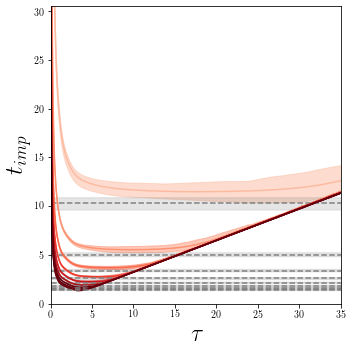

In [25]:
plt.figure(figsize=(5,5))
for kt in range(len(T_range)):
    ts_traj_delay = ts_traj_T[kt]

    mean = np.mean(1/ts_traj_delay[:,:,0],axis=0)
    #     kd = np.where(np.diff(mean)<np.min(std))[0][1]
    kd = np.argmax(mean)
    print(kd,delay_range[kd]*dt)

    mean = np.mean(ts_traj_delay[:,:,0],axis=0)
    cil = np.percentile(ts_traj_delay[:,:,0],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,0],97.5,axis=0)
    print(np.array([mean[kd],cil[kd],ciu[kd]])*2)
    
    plt.plot(delay_range*dt,mean,c=colors_[kt])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_[kt])
    plt.plot(delay_range*dt,np.ones(len(mean))*half_tscales_T_ci[kt,0],c='gray',ls='--')
    plt.fill_between(delay_range*dt,np.ones(len(mean))*half_tscales_T_ci[kt,1],np.ones(len(mean))*half_tscales_T_ci[kt,2],color='gray',alpha=.2)

plt.ylim(0,30.5)
plt.xlim(0,35)
plt.xlabel(r'$\tau$',fontsize=24)
plt.ylabel(r'$t_{imp}$',fontsize=25)
plt.tight_layout()
# plt.savefig('timp_decay_rate.pdf')
plt.show()

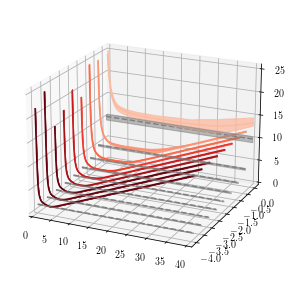

In [26]:
from mpl_toolkits.mplot3d import Axes3D
x = delay_range*dt
zmax=25.5
xmax=40.5
sel_x = x<xmax
offset=.5

plt.figure(figsize=(5,5))
ax = plt.subplot(projection='3d')
angles = [20,-65]
ax.view_init(angles[0],angles[1])

    
for kt in np.arange(len(T_range)):
    y = np.zeros(x.size)-kt*offset
    z_operator = y_operator[kt]
    z_data = y_data[kt]
    sel_zo = np.logical_and(x<xmax,z_operator[2]<zmax)

    ax.plot(x[sel_zo],y[sel_zo],z_operator[0][sel_zo],c=colors_[kt])
    ax.add_collection3d(plt.fill_between(x[sel_zo],z_operator[1][sel_zo],z_operator[2][sel_zo],alpha=.5,color=colors_[kt]),zs = -kt*offset,zdir='y')
    ax.plot(x[sel_x],y[sel_x],np.ones(len(mean))[sel_x]*z_data[0],c='gray',ls='--')
    ax.add_collection3d(plt.fill_between(x[sel_x],np.ones(len(mean))[sel_x]*z_data[1],np.ones(len(mean))[sel_x]*z_data[2],color='gray',alpha=.3),zs = -kt*offset,zdir='y')
ax.set_zlim3d(0,zmax)
ax.set_xlim3d(0,xmax)
# plt.xticks(np.arange(0,41,10))
# plt.yticks(np.arange(0.5,))
# plt.savefig('tscales_DW_3d_{}_{}.pdf'.format(angles[0],angles[1]))
plt.show()
    

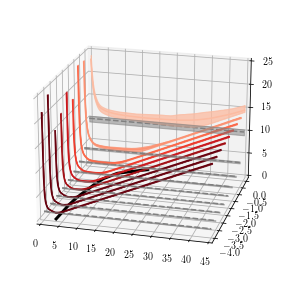

In [27]:
from mpl_toolkits.mplot3d import Axes3D
x = delay_range*dt
zmax=25
xmax=45
sel_x = x<xmax
offset=.5

plt.figure(figsize=(5,5))
ax = plt.subplot(projection='3d')
angles = [20,-75]
ax.view_init(angles[0],angles[1])

ax.plot(delay_idx_T*dt,np.linspace(-4,0,len(T_range))[::-1],np.zeros(len(T_range)),c='k',lw=3)    
for kt in np.arange(len(T_range)):
    y = np.zeros(x.size)-kt*offset
    z_operator = y_operator[kt]
    z_data = y_data[kt]
    sel_zo = np.logical_and(x<xmax,z_operator[2]<zmax)

    ax.plot(x[sel_zo],y[sel_zo],z_operator[0][sel_zo],c=colors_[kt])
    ax.add_collection3d(plt.fill_between(x[sel_zo],z_operator[1][sel_zo],z_operator[2][sel_zo],alpha=.5,color=colors_[kt]),zs = -kt*offset,zdir='y')
    ax.plot(x[sel_x],y[sel_x],np.ones(len(mean))[sel_x]*z_data[0],c='gray',ls='--')
    ax.add_collection3d(plt.fill_between(x[sel_x],np.ones(len(mean))[sel_x]*z_data[1],np.ones(len(mean))[sel_x]*z_data[2],color='gray',alpha=.3),zs = -kt*offset,zdir='y')
ax.set_zlim3d(0,zmax)
ax.set_xlim3d(0,xmax)
# plt.savefig('tscales_DW_3d_{}_{}.pdf'.format(angles[0],angles[1]))
plt.show()
    

# Sup Fig eigfuns

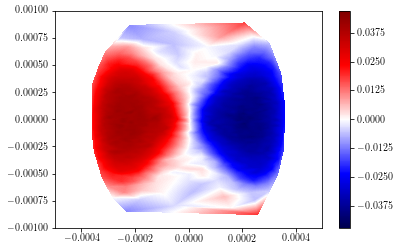

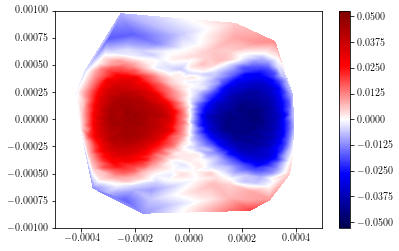

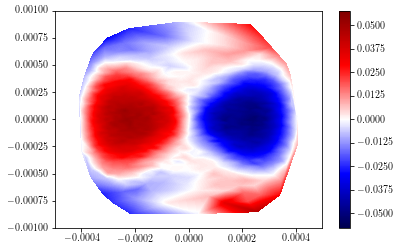

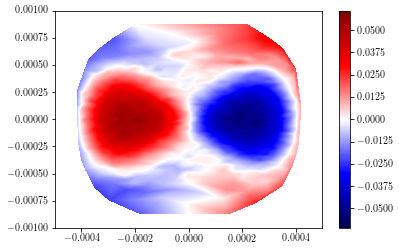

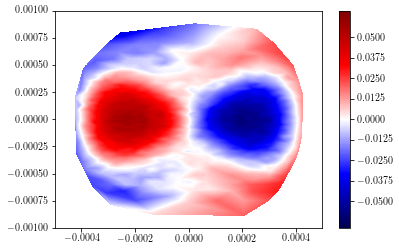

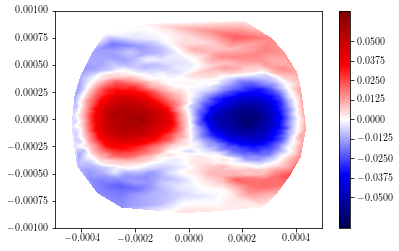

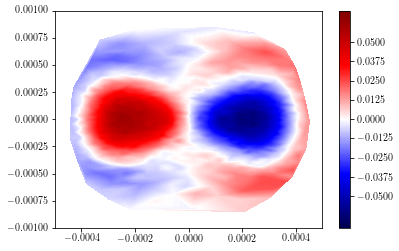

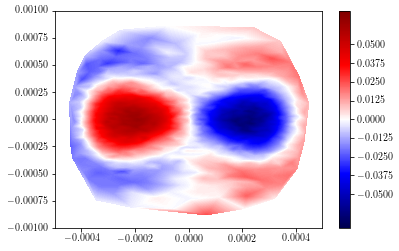

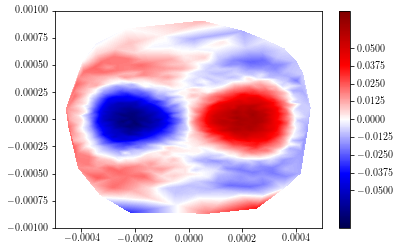

In [28]:
# kd=14


for kt,k_B_T in enumerate(T_range):
    delay=delay_idx_T[kt]
    f = h5py.File(dir_path+'DoubleWell/symbol_sequences/labels_phspace_k_B_T_{}_nseeds_1000.h5'.format(k_B_T),'r')
    labels = ma.array(f['labels_phspace'],dtype=int)
    centers = np.array(f['centers_phspace'])
    f.close()

    lcs,P = op_calc.transition_matrix(labels,delay,return_connected=True)
    inv_measure = op_calc.stationary_distribution(P)
    final_labels = op_calc.get_connected_labels(labels,lcs)
    n_modes=2
    R = op_calc.get_reversible_transition_matrix(P)
    eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
    eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
    phi2 = eigfunctions[:,1]

    plt.figure()
    cmax = np.max(np.abs(eigvecs[:,1].real))
    plt.tricontourf(centers[:,0],centers[:,1],eigvecs[:,1].real,cmap='seismic',levels=np.linspace(-1.1*cmax,1.1*cmax,1000))
    plt.xlim(-0.0005,0.0005)
    plt.ylim(-0.001,0.001)
    plt.colorbar(ticks = np.linspace(-0.05,0.05,9))

#     plt.savefig('Koopman_eigfun_DW_k_B_T_{}.pdf'.format(k_B_T))
    plt.show()


# SVD subfigure

In [29]:
u,s,v = np.linalg.svd(traj_matrix,full_matrices=False)

In [30]:
bootstrap_s = []
for k in range(100):
    random_indices = np.random.randint(0,len(traj_matrix),len(traj_matrix))
    _,s_,_ = np.linalg.svd(traj_matrix[random_indices],full_matrices=False)
    bootstrap_s.append(s_)
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [31]:
bootstrap_s = np.array(bootstrap_s)
cum_sum_boot = (np.cumsum(bootstrap_s**2,axis=1).T/np.sum(bootstrap_s**2,axis=1)).T
std = np.std(cum_sum_boot,axis=0)

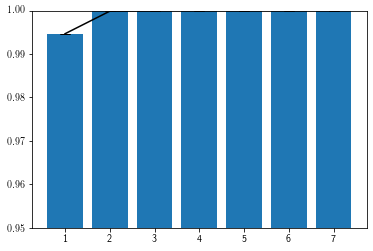

In [32]:
plt.bar(range(len(s)),np.cumsum(s**2)/np.sum(s**2),yerr = std,capsize=5)
plt.ylim(0.95,1)
plt.plot(range(len(s)),np.cumsum(s**2)/np.sum(s**2),c='k')
plt.xticks(np.arange(7),np.arange(1,8))
# plt.xlabel('# svd modes')
# plt.ylabel('cumsum(s^2)')
# plt.savefig('svd_spectrum.pdf')
plt.show()

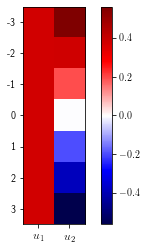

In [33]:
plt.imshow(-v[:2,:].T,cmap='seismic',extent=[-0.5,1.5,-0.5,6.5])
plt.xticks([0,1],['$u_1$','$u_2$'],fontsize=12)
plt.yticks(np.arange(0,7),np.arange(-3,4)[::-1])
plt.colorbar()
# plt.savefig('svd_modes.pdf')
plt.show()